### Data Ingestion

##### Loading libraries

In [335]:
import os

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

##### Loading dataset to a dataframe

In [336]:
os.chdir('..')
os.chdir('data')

In [337]:
dataframe= pd.read_csv('heart_failure_prediction_dataset.csv')

In [338]:
os.chdir('..')
os.chdir('notebooks')

### Assessing the Data

#### Checking NaN values

In [339]:
dataframe.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

##### Observations
- Dataframe doesn't contain any NaN values.

#### Checking duplicated rows

In [340]:
dataframe.duplicated().sum()

0

##### Observations:
- Dataframe doesn't contain any duplicated values.

#### Checking data type for columns

In [341]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### Checking descriptive stats.

In [342]:
dataframe.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


##### Observations:
- Minimum value for `RestingBP` is 0, which is not physiologically possible.
- Minimum `Cholesterol` level is 0, which is not physiologically possible.
- `FastingBS` is a categorical feature.

### Handling Data Integrity Issues

##### Creating helper functions for data manipulation

In [343]:
def set_lower_bound(column, k= 1.5):
    # nested function to calculate lower bound
    def calculate_lower_bound(column, k):
        Q1= np.percentile(dataframe[column], 25)
        Q3= np.percentile(dataframe[column], 75)
        IQR= Q3 - Q1
        # Lower Bound = First Quartile - contant x Inter Quartile Range
        LB= Q1 - k*IQR
        return LB
    
    # using nested function for calculating lower bound
    print(f'Initial:\n{dataframe[column].describe()}\n')
    LB= calculate_lower_bound(column, k)
    dataframe[column]= list(map(lambda x: LB if x < LB else x, dataframe[column]))
    print(f'Final:\n{dataframe[column].describe()}')

In [344]:
def set_hard_threshold_lower_bound(column, threshold, imputed_value):
    print(f'Initial:\n{dataframe[column].describe()}\n')
    dataframe[column]= list(map(lambda x: imputed_value if x < threshold else x, dataframe[column]))
    print(f'Final:\n{dataframe[column].describe()}')

##### Setting lower bound for `RestingBP` using set_lower_bound.

In [345]:
set_lower_bound('RestingBP')

Initial:
count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

Final:
count    918.000000
mean     132.505447
std       18.015911
min       90.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64


##### Setting hard threshold of 125 for `Cholesterol` using set_hard_threshold_lower_bound.

- A common lower limit for total cholesterol in adults might be around 125 mg/dL, according to MedlinePlus.
  
Additionally, the general guidelines for cholesterol levels is shown below:
- Desirable: Less than 200 mg/dL
- Borderline High: 200 to 239 mg/dL
- High: 240 mg/dL and above

##### Calculating the number of patients under each condition segment

In [346]:
# Condition 1: Cholesterol <= 125
condition_1 = sum(dataframe.Cholesterol <= 125)
# Condition 2: 125 <= Cholesterol < 200
condition_2 = sum((dataframe.Cholesterol >= 125) & (dataframe.Cholesterol < 200))
# Condition 3: 200 <= Cholesterol < 240
condition_3 = sum((dataframe.Cholesterol >= 200) & (dataframe.Cholesterol < 240))
# Condition 4: Cholesterol >= 240
condition_4 = sum(dataframe.Cholesterol >= 240)

In [347]:
(condition_1, condition_2, condition_3, condition_4)

(179, 139, 237, 363)

Taking only patients with `HeartDisease` into consideration.

In [348]:
heart_patient_cholesterol= dataframe[dataframe.HeartDisease == 1].Cholesterol

Discounting data points from `heart_patient_cholesterol` list with `Cholesterol` below `125` .

In [349]:
heart_patient_cholesterol = [i for i in heart_patient_cholesterol if i>125]

Calculating the `median` for the value.

In [350]:
median_cholesterol= np.percentile(heart_patient_cholesterol, 50)

In [351]:
set_hard_threshold_lower_bound('Cholesterol', threshold= 125, imputed_value= median_cholesterol)

Initial:
count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

Final:
count    918.000000
mean     246.147059
std       51.919524
min      126.000000
25%      215.000000
50%      247.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


### Data Visualization

#### Understanding Target Column

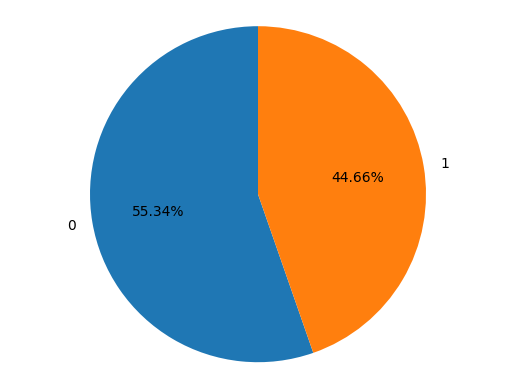

In [352]:
plt.pie(dataframe.HeartDisease.value_counts(),
        labels= dataframe.HeartDisease.unique(),
        autopct= '%0.2f%%',
        startangle= 90)
plt.axis('equal');

##### Observations:
- The data of target column is almost equally distributed.
- Number of `NormalPatients` is more than `HeartDisease` patients.

#### Age vs. HeartDisease

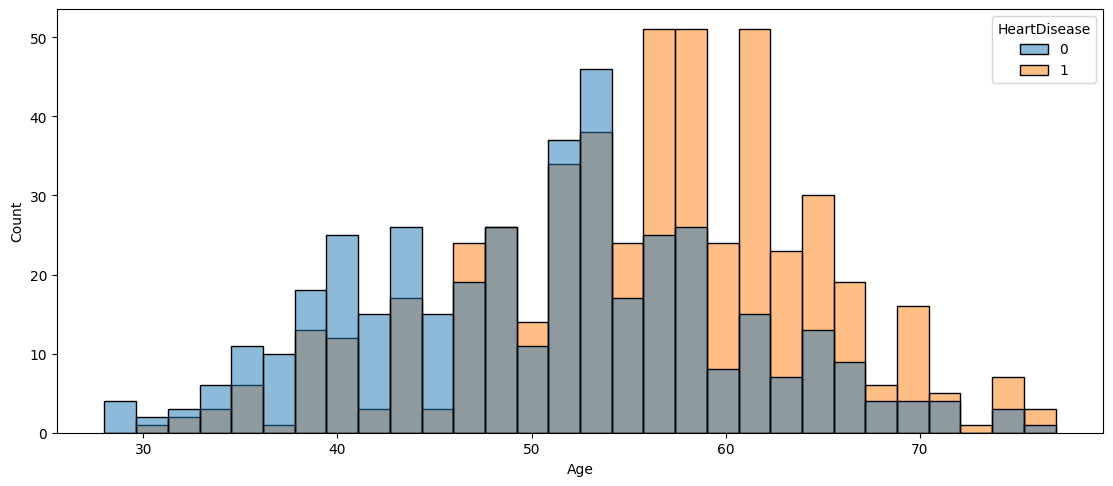

In [353]:
# calculating the number of bins
n_bins= int(np.sqrt(len(dataframe)))

plt.figure(figsize= (13.5, 5.5))
sns.histplot(x= dataframe.Age,
             hue= dataframe.HeartDisease,
             bins= n_bins);

##### Observations:
- Number of `HeartDisease` patients increase with increase in age.
- The data is left skewed which supports the first observation.

#### Sex vs. HeartDisease

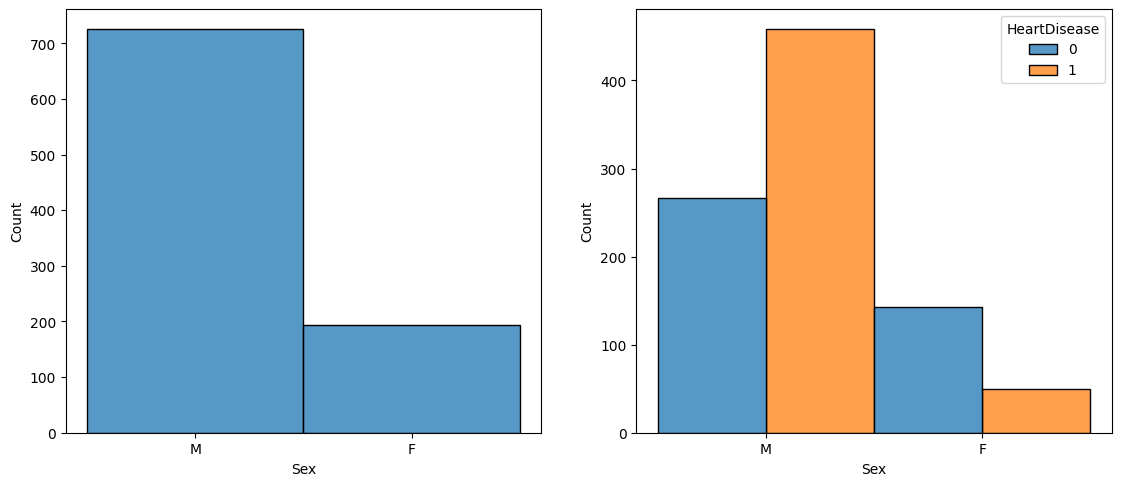

In [354]:
plt.figure(figsize= (13.5, 5.5))
plt.subplot(1,2,1)
sns.histplot(x= dataframe.Sex,
             multiple= 'dodge');
plt.subplot(1,2,2)
sns.histplot(x= dataframe.Sex,
             hue= dataframe.HeartDisease,
             multiple= 'dodge');

#### Observations:
- Total number of `M` patients is more than total number of `F` patients.
- `M` show higher susceptibility to get diagnosed with a heart disease.

#### ChestPainType Distribution

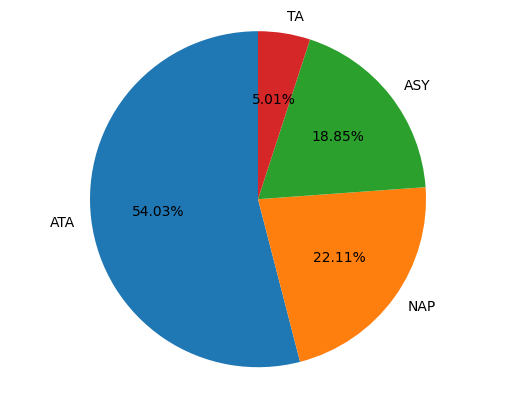

In [355]:
plt.pie(dataframe.ChestPainType.value_counts(),
        labels= dataframe.ChestPainType.unique(),
        autopct= '%0.2f%%',
        startangle= 90)
plt.axis('equal');

##### Observations:
- `ATA`: Atypical Angina is majority `ChestPainType` in the patients.
- `TA`: Typical Angina is minority `ChestPainType` in the patients.

#### RestingBP vs HeartDisease

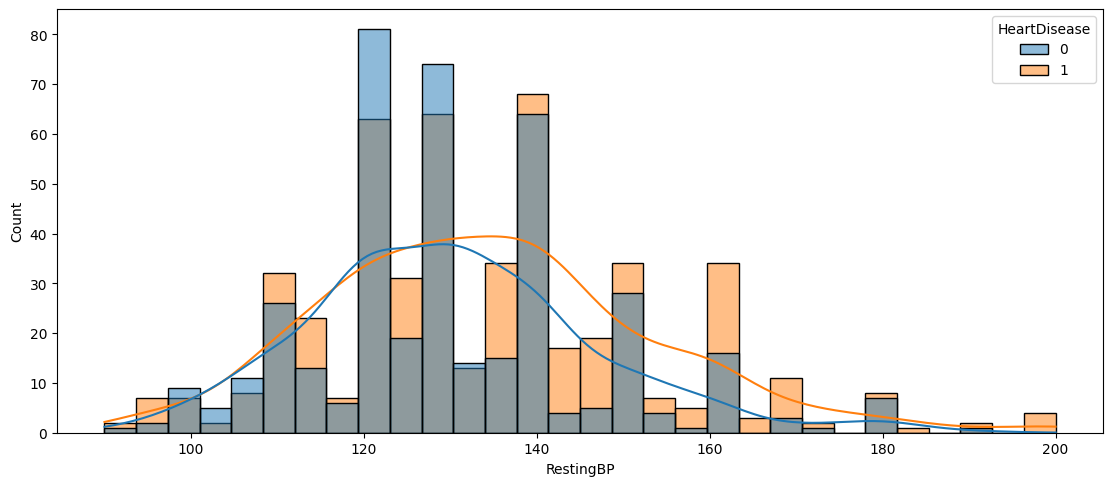

In [357]:
plt.figure(figsize= (13.5, 5.5))
sns.histplot(x= dataframe.RestingBP,
             hue= dataframe.HeartDisease,
             bins= n_bins,
             kde= True);

##### Observations:
- Data for both `Normal` and `HeartDisease` patients is right skewed.
- In relative terms, `HeartDisease` patients have a higher `RestingBP`.

#### Cholesterol vs. HeartDisease

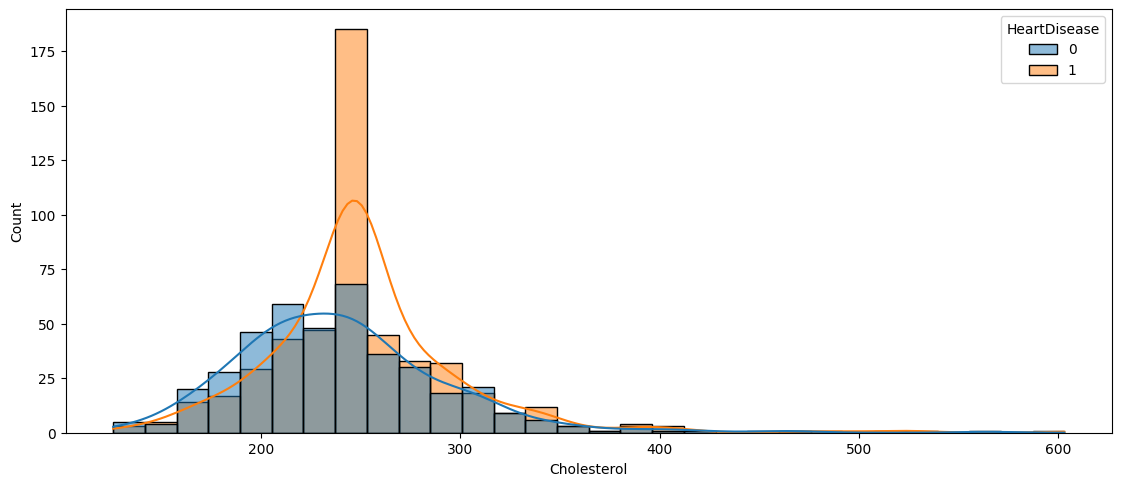

In [358]:
plt.figure(figsize= (13.5, 5.5))
sns.histplot(x= dataframe.Cholesterol,
             hue= dataframe.HeartDisease,
             bins= n_bins,
             kde= True);

##### Observations:
- Majority of patient's `Cholesterol` level is imputed at the `median_cholesterol` level for patients with `HeartDisease`.

#### ExerciseAngina vs. HeartDisease

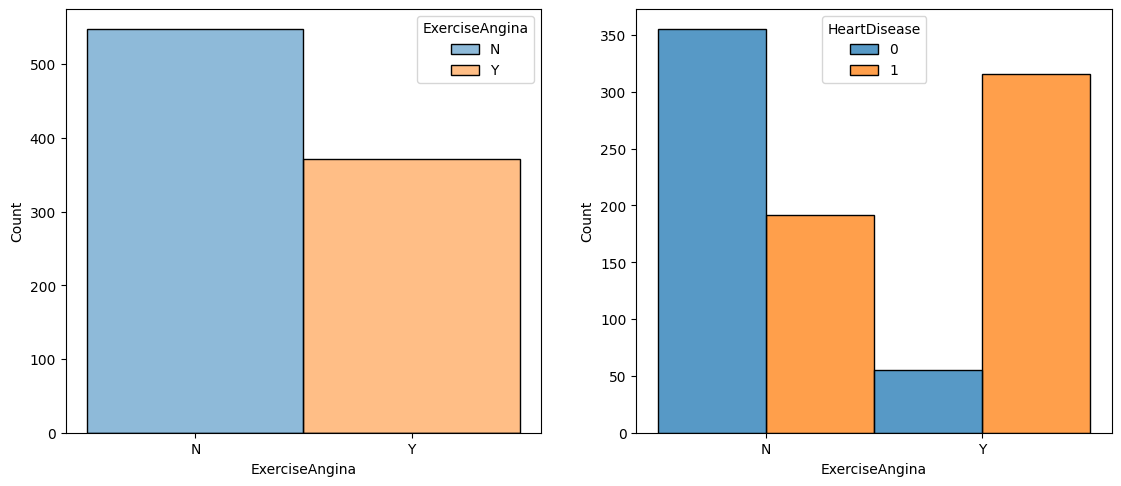

In [367]:
plt.figure(figsize= (13.5, 5.5))
plt.subplot(1,2,1)
sns.histplot(x= dataframe.ExerciseAngina,
             hue= dataframe.ExerciseAngina);
plt.subplot(1,2,2)
sns.histplot(x= dataframe.ExerciseAngina,
             hue= dataframe.HeartDisease,
             multiple= 'dodge');

##### Observations:
- Majority of patients didn't experience `ExerciseAngina`.
- Majority of patients who experienced `ExerciseAngina` were suffering from `HeartDisease`.